# Ignis T<sub>2</sub> Tests

> 5/17/19

This document uses Qiskit Ignis to run some T2 characterizations for the IBM devices. Since it pretty much follows `Ignis_T1_Tests.ipynb`, I won't document it in particularly great detail here.

In [15]:
# import quantum libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.ignis.characterization.coherence as ig
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

/home/eric/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [2]:
# snippet: wrapper to execute some circuit(s)
# this snippet depends on the quantum imports snippet
# parameters:
#   circuit: a single qiskit.QuantumCircuit or a list of them
#   shots, max_credits: self-explanatory
#   qubits: number of qubits needed (only necessary for auto-backend)
#   backend: either None (auto-choose leasy busy) or qiskit.IBMQBackend
#   opt: make circuit optimizations
# returns:
#   job: the job that ran
#   backend: the backend used
#   circuit: the circuit(s) used (for reproducibility)
def run(circuit, shots=1024, max_credits=10, qubits=5, backend=None, opt=True):

    if backend is None:
        # get least busy backend if not specified
        available = q.IBMQ.backends(filters=lambda x:
                                    x.configuration().n_qubits >= qubits
                                    and not
                                    x.configuration().simulator)
        backend = q.providers.ibmq.least_busy(available)

    manager = None
    if not opt:
        # disable optimization by adding a dummy pass manager
        manager = q.tools.compiler.PassManager()

    # execute job
    job = q.execute(circuit, backend=backend, shots=shots,
                    max_credits=max_credits, pass_manager=manager)
    monitor.job_monitor(job)

    # print job info for later retrieval if necessary
    print('Job ID \'%s\'' % job.job_id())
    print('Ran on backend \'%s\'' % backend.name())
    print('Completed %s' % job.creation_date())

    return job, backend, circuit

In [3]:
# snippet: retrieve an old qiskit job from job id and backend name
def get_job(job_id, backend_name):
    backend = q.IBMQ.get_backend(backend_name)
    return backend.retrieve_job(job_id)

In [23]:
# get least busy backend to keep consistent
available = q.IBMQ.backends(filters=lambda x:
                            x.configuration().n_qubits >= 1
                            and not
                            x.configuration().simulator)
backend = q.providers.ibmq.least_busy(available)

job_ids = []
for i in range(5):
    # test one qubit at a time to avoid too large a payload
    delays = np.arange(0, 1000, 75)
    circuits, delays = ig.circuits.t2_circuits(num_of_gates=delays, gate_time=0.08333, qubits=[i])
    job, backend, _ = run(circuits, backend=backend)
    job_ids += [job.job_id()]

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdeedc53c65ac0076f93be9'
Ran on backend 'ibmqx2'
Completed 2019-05-17T17:22:12.882Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdeee3d24773d006b42febb'
Ran on backend 'ibmqx2'
Completed 2019-05-17T17:24:12.726Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdeeeb16c8d850076bc56da'
Ran on backend 'ibmqx2'
Completed 2019-05-17T17:26:08.798Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdeef2d4f5309006d269f9d'
Ran on backend 'ibmqx2'
Completed 2019-05-17T17:28:13.440Z


HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cdeefdc74321e007233f9c2'
Ran on backend 'ibmqx2'
Completed 2019-05-17T17:31:07.980Z


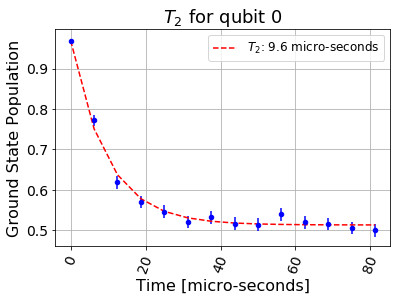

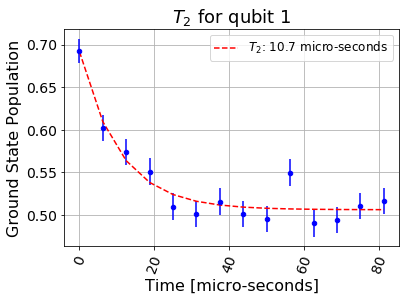

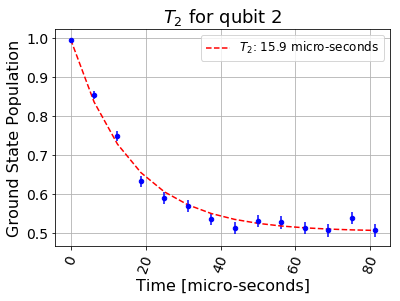

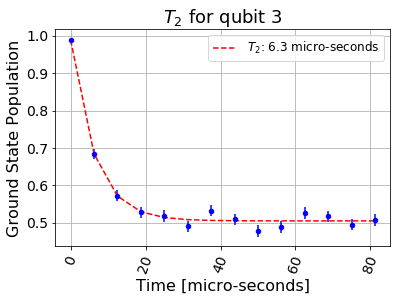

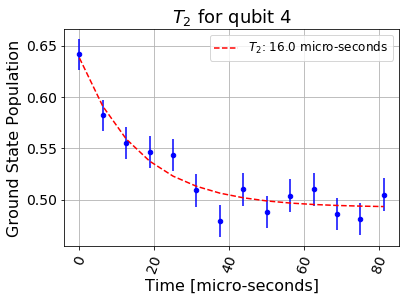

In [25]:
# easier to replicate later
job_ids = ['5cdeedc53c65ac0076f93be9',
           '5cdeee3d24773d006b42febb',
           '5cdeeeb16c8d850076bc56da',
           '5cdeef2d4f5309006d269f9d',
           '5cdeefdc74321e007233f9c2']

for i in range(5):
    job = get_job(job_ids[i], 'ibmqx2')
    delays = np.arange(0, 1000, 75) * 0.08333
    fit = ig.fitters.T2Fitter(job.result(), delays, [i], fit_p0=[1, 10, 0], fit_bounds=([0, 0, -1], [2, 80, 1]))
    fit.fit_data(0)
    fit.plot(0)

Well, that was pretty disappointing. I'm going to try T2* tests in another notebook, since apparently that's a thing. Actually, one such test is below:

regression eqn. is: 0.458305 exp(-t / 17.124365) * cos(2pi * 0.128526 * t + -0.001335) + 0.509832


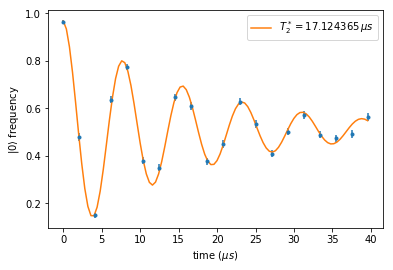

In [96]:
from scipy.optimize import curve_fit

delays = np.arange(0, 500, 25)

def count_results(result, circuits, shots=1024):
    freq = []    # frequency of '0' state
    stderr = []  # standard error

    for c in circuits:
        trial = Counter(result.get_counts(c))
        p = trial['0'] / shots
        freq += [p]
        stderr += [np.sqrt(p * (1 - p) / shots)]
    return freq, stderr

circuits, delays, freq = ig.circuits.t2star_circuits(num_of_gates=delays, gate_time=0.08333, qubits=[0], nosc=5)
# job, backend, _ = run(circuits, backend=backend)
job = get_job('5cdf061224773d006b42fede', 'ibmqx2')

p, s = count_results(job.result(), circuits)
fig, ax = plt.subplots()
ax.errorbar(delays, p, s, linestyle='None', marker='.')
ax.set_xlabel(r'time ($\mu s$)')
ax.set_ylabel(r'$\vert 0 \rangle$ frequency')

def damped_cos(t, a, b, c, d, e):
    # fully parameterized damped oscillation model
    return a * np.exp(-t / b) * np.cos(2 * np.pi * c * t + d) + e

params = curve_fit(damped_cos, delays, p, p0=[1, 30, freq, 0, 0.5],
                   bounds=([-0.5,  0,                0, -np.pi, -0.5],
                           [ 1.5, 40, 2 * np.pi * freq,  np.pi,  1.5]),
                   sigma=s)[0]
print('regression eqn. is: %f exp(-t / %f) * cos(2pi * %f * t + %f) + %f' % tuple(params))
xs = np.linspace(0, max(delays), 100)
ax.plot(xs, damped_cos(xs, *params), label=r'$T_2^* = %f\,\mu s$' % b)
ax.legend()